# Predict the formation energy and band-gap energy of semicondoctors

<font color='blue'>
## 1. Load the data

<font color='blue'> 
First load some modules

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf

import itertools

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.unicode_minus'] = False

<font color='blue'>
Load the data and rename the columns

In [15]:
df_data = pd.read_csv('train.csv')
df_data = df_data.rename(columns={'spacegroup' : 'sg',
                        'number_of_total_atoms' : 'Natoms',
                        'percent_atom_al' : 'x_Al',
                        'percent_atom_ga' : 'x_Ga',
                        'percent_atom_in' : 'x_In',
                        'lattice_vector_1_ang' : 'a',
                        'lattice_vector_2_ang' : 'b',
                        'lattice_vector_3_ang' : 'c',
                        'lattice_angle_alpha_degree' : 'alpha',
                        'lattice_angle_beta_degree' : 'beta',
                        'lattice_angle_gamma_degree' : 'gamma',
                        'formation_energy_ev_natom' : 'E',
                        'bandgap_energy_ev' : 'Eg'})
#df_data.head()

<font color='blue'>
More details on how the data looks

In [16]:
#df_data.describe()

<font color='blue'>
Now let's define some functions that we will use later.
First, the function to plot:

In [17]:
# function to visualize data using scatter plots
def plot_scatter(df_data, x, y, xlabel, ylabel):
    """
    Args:
        x (str) - DataFrame column for x-axis
        y (str) - DataFrame column for y-axis
        xlabel (str) - name for x-axis
        ylabel (str) - name for y-axis
    Returns:
        matplotlib scatter plot of y vs x
    """
    s = 75
    lw = 0
    alpha = 0.05
    color = 'blue'
    marker = 'o'
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 16
    label = '__nolegend__'
    ax = plt.scatter(df_data[x].values, df_data[y].values,
                     marker=marker, color=color, s=s, 
                     lw=lw, alpha=alpha, label=label)
    xrange = abs(df_data[x].max() - df_data[x].min())
    yrange = abs(df_data[y].max() - df_data[y].min())
    cushion = 0.1
    xmin = df_data[x].min() - cushion*xrange
    xmax = df_data[x].max() + cushion*xrange
    ymin = df_data[y].min() - cushion*yrange
    ymax = df_data[y].max() + cushion*yrange
    ax = plt.xlim([xmin, xmax])
    ax = plt.ylim([ymin, ymax])
    ax = plt.xlabel(xlabel, fontsize=fontsize)
    ax = plt.ylabel(ylabel, fontsize=fontsize)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    return ax

<font color='blue'>
Function to plot important features

In [18]:
# plot the feature importances
def plot_importances(X_train, sorted_features, sorted_importances):
    """
    Args:
        X_train (nd-array) - feature matrix of shape (number samples, number features)
        sorted_features (list) - feature names (str)
        sorted_importances (list) - feature importances (float)
    Returns:
        matplotlib bar chart of sorted importances
    """
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'lightblue'
    align = 'center'
    label = '__nolegend__'
    ax = plt.bar(range(X_train.shape[1]), sorted_importances,
                 color=bar_color, align=align, label=label)
    ax = plt.xticks(range(X_train.shape[1]), sorted_features, rotation=90)
    ax = plt.xlim([-1, X_train.shape[1]])
    ax = plt.ylabel('Average impurity decrease', fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

<font color='blue'>
To evaluate performance of the random forest models

In [19]:
# evaluate performance of the random forest models
def rmsle(actual, predicted):
    """
    Args:
        actual (1d-array) - array of actual values (float)
        predicted (1d-array) - array of predicted values (float)
    Returns:
        root mean square log error (float)
    """
    return np.sqrt(np.mean(np.power(np.log1p(actual)-np.log1p(predicted), 2)))

def plot_actual_pred(train_actual, train_pred, 
                     test_actual, test_pred,
                     target):
    """
    Args:
        train_actual (1d-array) - actual training values (float)
        train_pred (1d-array) - predicted training values (float)
        test_actual (1d-array) - actual test values (float)
        test_pred (1d-array) - predicted test values (float)
        target (str) - target property
    Returns:
        matplotlib scatter plot of actual vs predicted
    """
    s = 75
    lw = 0
    alpha = 0.2
    train_color = 'orange'
    train_marker = 's'
    test_color = 'blue'
    test_marker = '^'
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 16
    label = '__nolegend__'
    ax = plt.scatter(train_pred, train_actual,
                     marker=train_marker, color=train_color, s=s, 
                     lw=lw, alpha=alpha, label='train')
    ax = plt.scatter(test_pred, test_actual,
                     marker=test_marker, color=test_color, s=s, 
                     lw=lw, alpha=alpha, label='test')
    ax = plt.legend(frameon=False, fontsize=fontsize, handletextpad=0.4)    
    all_vals = list(train_pred) + list(train_actual) + list(test_pred) + list(test_actual)
    full_range = abs(np.max(all_vals) - np.min(all_vals))
    cushion = 0.1
    xmin = np.min(all_vals) - cushion*full_range
    xmax = np.max(all_vals) + cushion*full_range
    ymin = xmin
    ymax = xmax    
    ax = plt.xlim([xmin, xmax])
    ax = plt.ylim([ymin, ymax])
    ax = plt.plot([xmin, xmax], [ymin, ymax], 
                  lw=axis_width, color='black', ls='--', 
                  label='__nolegend__')
    ax = plt.xlabel('predicted ' + target, fontsize=fontsize)
    ax = plt.ylabel('actual ' + target, fontsize=fontsize)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    return ax

<font color='blue'>
Main function for RandomForestRegressor

In [20]:
def modelRandomForestRegressor(X, y_E, y_Eg):
    # split into training and test for the purposes of this demonstration
    test_size = 0.2
    rstate = 42
    X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X, y_E, 
                                                                test_size=test_size,
                                                                random_state=rstate)
    X_train_Eg, X_test_Eg, y_train_Eg, y_test_Eg = train_test_split(X, y_Eg, 
                                                                test_size=test_size, 
                                                                random_state=rstate)
    # number of base decision tree estimators
    n_est = 100
    max_depth = 5
    
    rf_E = RandomForestRegressor(n_estimators=n_est, 
                                 max_depth=max_depth,
                                 random_state=rstate)
    rf_Eg = RandomForestRegressor(n_estimators=n_est, 
                                 max_depth=max_depth,
                                 random_state=rstate)
    # fit to training data
    rf_E.fit(X_train_E, y_train_E)
    rf_Eg.fit(X_train_Eg, y_train_Eg)
    
    # collect ranking of most "important" features for E
    importances_E =  rf_E.feature_importances_
    descending_indices_E = np.argsort(importances_E)[::-1]
    sorted_importances_E = [importances_E[idx] for idx in descending_indices_E]
    sorted_features_E = [features[idx] for idx in descending_indices_E]
    print('most important feature for formation energy is %s' % sorted_features_E[0])
    
    # collect ranking of most "important" features for Eg
    importances_Eg =  rf_Eg.feature_importances_
    descending_indices_Eg = np.argsort(importances_Eg)[::-1]
    sorted_importances_Eg = [importances_Eg[idx] for idx in descending_indices_Eg]
    sorted_features_Eg = [features[idx] for idx in descending_indices_Eg]
    print('most important feature for band gap is %s' % sorted_features_Eg[0])
    
    fig3 = plt.figure(3, figsize=(11,6))
    ax1 = plt.subplot(121)
    ax1 = plot_importances(X_train_E, sorted_features_E, sorted_importances_E)
    ax1 = plt.legend(['formation energy'], fontsize=14, frameon=False)
    ax2 = plt.subplot(122)
    ax2 = plot_importances(X_train_Eg, sorted_features_Eg, sorted_importances_Eg)
    ax2 = plt.legend(['band gap'], fontsize=14, frameon=False)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    
    y_train_E_pred = rf_E.predict(X_train_E)
    y_test_E_pred = rf_E.predict(X_test_E)
    target_E = 'formation energy (eV/atom)'
    print('RMSLE for formation energies = %.3f eV/atom (training) and %.3f eV/atom (test)' 
          % (rmsle(y_train_E, y_train_E_pred),  (rmsle(y_test_E, y_test_E_pred))))
    y_train_Eg_pred = rf_Eg.predict(X_train_Eg)
    y_test_Eg_pred = rf_Eg.predict(X_test_Eg)
    target_Eg = 'band gap (eV)'
    print('RMSLE for band gaps = %.3f eV (training) and %.3f eV (test)' 
          % (rmsle(y_train_Eg, y_train_Eg_pred), (rmsle(y_test_Eg, y_test_Eg_pred))))
    fig4 = plt.figure(4, figsize=(11,5))
    ax1 = plt.subplot(121)
    ax1 = plot_actual_pred(y_train_E, y_train_E_pred,
                           y_test_E, y_test_E_pred,
                           target_E)
    ax2 = plt.subplot(122)
    ax2 = plot_actual_pred(y_train_Eg, y_train_Eg_pred,
                           y_test_Eg, y_test_Eg_pred,
                           target_Eg)
    plt.tight_layout()
    plt.show()
    plt.close()

## 2. Explore the data

<font color='blue'>
There are several features in the data, we can plot the formation energy and band-gap energy as a function of a chosen feature, for example, parameter "c" as follow:

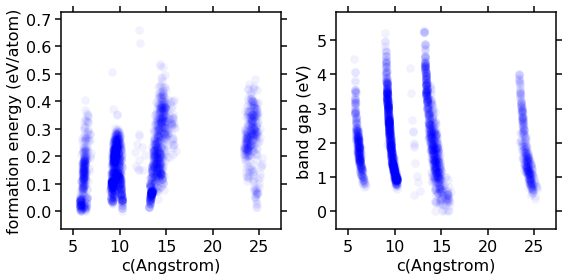

In [21]:
fig1 = plt.figure(1, figsize=(8, 4))
ax1 = plt.subplot(121)
ax1 = plot_scatter(df_data, 'c', 'E', 
                   'c(Angstrom)', 'formation energy (eV/atom)')
ax2 = plt.subplot(122)
ax2 = plot_scatter(df_data, 'c', 'Eg', 
                   'c(Angstrom)', 'band gap (eV)')
plt.tight_layout()
plt.show()
plt.close()

## 3. Machine learning model
### a. RandomForestRegressor

<font color='blue'>
We will found that there is no simple dependence on those features. Now first try to work only with all features we have. First, create the input needed for RandomForestRegressor

11 features: ['sg', 'Natoms', 'x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'alpha', 'beta', 'gamma']
most important feature for formation energy is c
most important feature for band gap is x_In


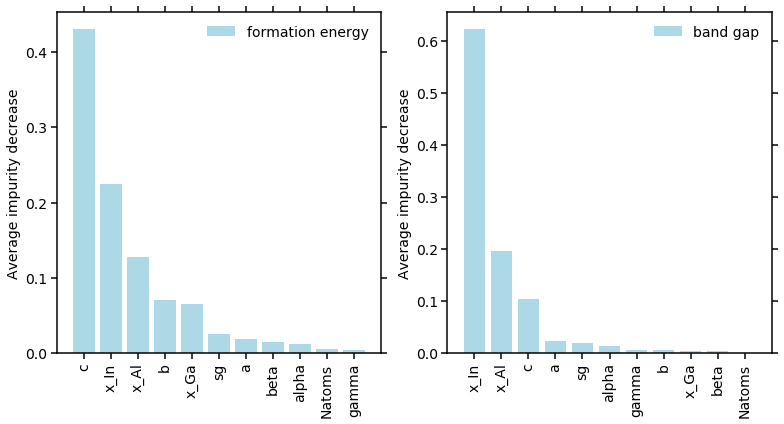

RMSLE for formation energies = 0.033 eV/atom (training) and 0.041 eV/atom (test)
RMSLE for band gaps = 0.094 eV (training) and 0.103 eV (test)


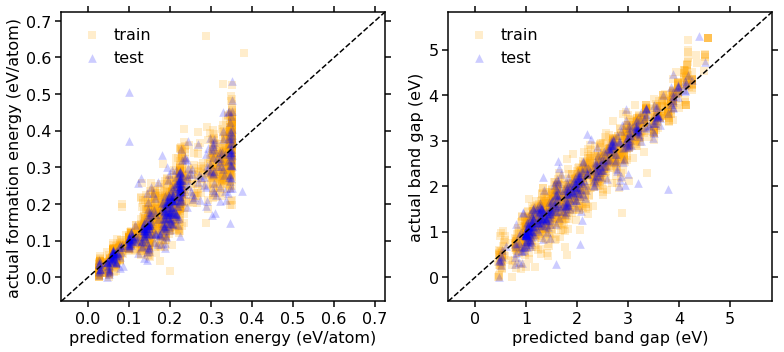

In [22]:
non_features = ['id', 'E', 'Eg']
features = [col for col in list(df_data) if col not in non_features]
print('%i features: %s' % (len(features), features))

# make feature matrix
X = df_data[features].values

# make target columns for each target property
y_E = df_data['E'].values
y_Eg = df_data['Eg'].values
modelRandomForestRegressor(X, y_E, y_Eg)

<font color='blue'>
And run the model

<font color='blue'>
The result is ok, now the question is can we improve the accuracy by adding more features. The new features should come from the physics. Let's try to add the unit-cell volume and the atomic density.

In [23]:
def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    alphaR = alpha * np.pi/180
    betaR = beta * np.pi/180
    gammaR = gamma * np.pi/180
    return a*b*c*np.sqrt(1 + 2*np.cos(alphaR)*np.cos(betaR)*np.cos(gammaR)
                           - np.cos(alphaR)**2
                           - np.cos(betaR)**2
                           - np.cos(gammaR)**2)
# unit-cell volume
df_data['vol'] = get_vol(df_data['a'], df_data['b'], df_data['c'],
                          df_data['alpha'], df_data['beta'], df_data['gamma'])
df_data['atomic_density'] = df_data['Natoms'] / df_data['vol']   

13 features: ['sg', 'Natoms', 'x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'vol', 'atomic_density']
most important feature for formation energy is c
most important feature for band gap is atomic_density


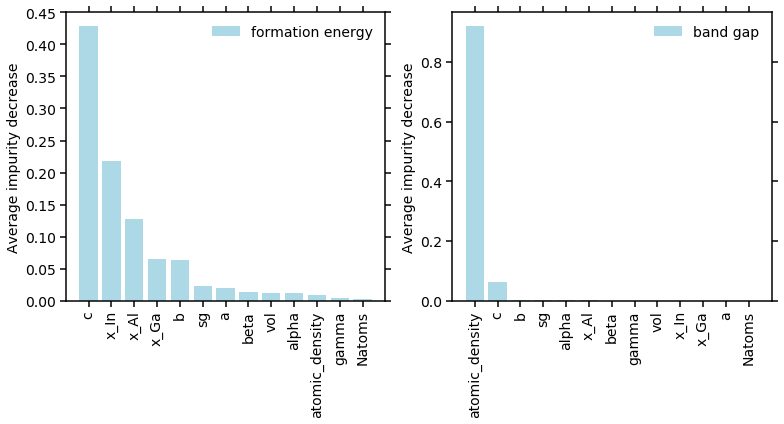

RMSLE for formation energies = 0.033 eV/atom (training) and 0.041 eV/atom (test)
RMSLE for band gaps = 0.088 eV (training) and 0.096 eV (test)


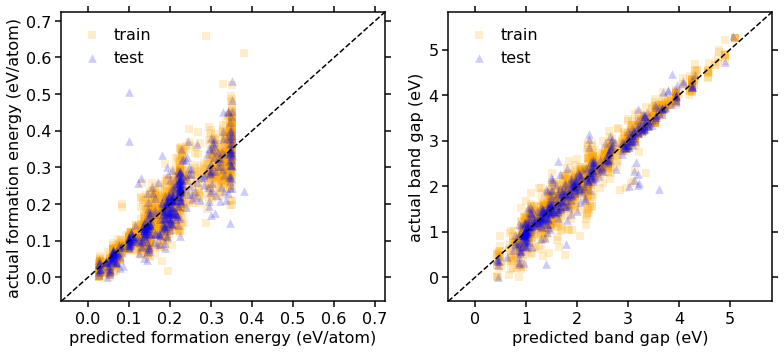

In [26]:
non_features = ['id', 'E', 'Eg']
features = [col for col in list(df_data) if col not in non_features]
print('%i features: %s' % (len(features), features))

# make feature matrix
X = df_data[features].values

# make target columns for each target property
y_E = df_data['E'].values
y_Eg = df_data['Eg'].values
modelRandomForestRegressor(X, y_E, y_Eg)

<font color='blue'>
The result of the band gap improves a little bit.
Now, let's try to add the BZ cell to the dataframe

<font color='blue'>
The result is almost the same, probably this is the critical point that we can reach out with RandomForestRegressor